In [1]:
import data_preprocessing_cleaned as clean

def clean_data(csv_file:str): 
    df = clean.TweetCleaner(csv_file)
    cleaned_df = df.clean_tweets()
    #cleaned_df['preprocessed_text'] = cleaned_df['cleaned_text'].apply(clean.preprocess_text_lemmatization)
    return cleaned_df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#nltk.download('wordnet')
df = clean_data('twitter_data.csv')

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def preprocess(text):
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {'u', 'would', 'amp', 'im', 'ur'}
    stop_words.update(additional_stopwords)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

df['processed_text'] = df['cleaned_text'].apply(preprocess)

In [4]:
df

,Unnamed: 0,hashed_userid,masked_username,location,following,followers,totaltweets,usercreateddt,tweetid,tweetcreatedts,...,language,favorite_count,is_retweet,original_tweet_id,in_reply_to_status_id,is_quote_status,quoted_status_id,extractedts,cleaned_text,processed_text
0,0,13028308852725196659,*****roy1,NaN,9590,8725,29317,2012-01-24,1542763288815030273,2022-07-01 06:53:25,...,en,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.185425,for 49 years libertys torch shone to ensure ba...,"[49, year, liberty, torch, shone, ensure, basi..."
1,1,45494576030177085457,******eam_6,NaN,8874,10090,33053,2019-02-07,1542763315926994945,2022-07-01 06:53:32,...,en,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.171429,for 49 years libertys torch shone to ensure ba...,"[49, year, liberty, torch, shone, ensure, basi..."
2,2,23641094384211702614,******erlin,"Los Angeles, CA",7730,10006,35360,2008-08-07,1542763330670014464,2022-07-01 06:53:35,...,en,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.157331,for 49 years libertys torch shone to ensure ba...,"[49, year, liberty, torch, shone, ensure, basi..."
3,3,21587659761682762378,******oshi23,Mumbai,232,132,4970,2016-05-10,1542763339738382337,2022-07-01 06:53:38,...,en,0,True,1542707138971242496,0,False,0,2022-07-01 12:03:31.123276,home based church are now everywhere in punjab...,"[home, based, church, everywhere, punjab, hary..."
4,4,47915146590553055505,******4Truth,NaN,6914,6310,49958,2021-04-02,1542763352279003136,2022-07-01 06:53:40,...,en,0,True,1542689411489337344,0,False,0,2022-07-01 12:03:31.097582,for 49 years libertys torch shone to ensure ba...,"[49, year, liberty, torch, shone, ensure, basi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415367,415367,83242079331442835051,*******tresist,NaN,257,758,272531,2017-02-16,1560822761706094592,2022-08-20 02:55:19,...,en,0,True,1560794896663203840,0,False,0,2022-08-20 02:58:51.096736,womensrights 15 sandytxresister crystal4whales...,"[womensrights, 15, sandytxresister, crystal4wh..."
415368,415368,98949018742144878760,*****ll42,NaN,603,179,59766,2014-03-14,1560822898780213249,2022-08-20 02:55:52,...,en,0,True,1560750229720563712,0,False,0,2022-08-20 02:58:51.087505,aaronparnas patryanuc ny newyork yankees mets ...,"[aaronparnas, patryanuc, ny, newyork, yankee, ..."
415369,415369,42256911176251501556,*******eDuster,Chi-town,416,8852,11699,2009-03-26,1560823151671488513,2022-08-20 02:56:52,...,en,0,True,1560280488488718336,0,False,0,2022-08-20 02:58:51.077181,the 19th amendment was ratified onthisday in 1...,"[19th, amendment, ratified, onthisday, 1920, g..."
415370,415370,95273352056344375133,*****kh59,"Terre Haute, IN",854,298,16999,2017-10-10,1560823347583361024,2022-08-20 02:57:39,...,en,0,False,0,1560769551347900416,False,0,2022-08-20 02:58:51.066790,cbouzy filmystic yes we are not happy we are a...,"[cbouzy, filmystic, yes, happy, angry, mybodym..."


In [5]:
from gensim.corpora import Dictionary

# Create a Gensim dictionary from the processed text
dictionary = Dictionary(df['processed_text'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create a corpus: a list of bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]


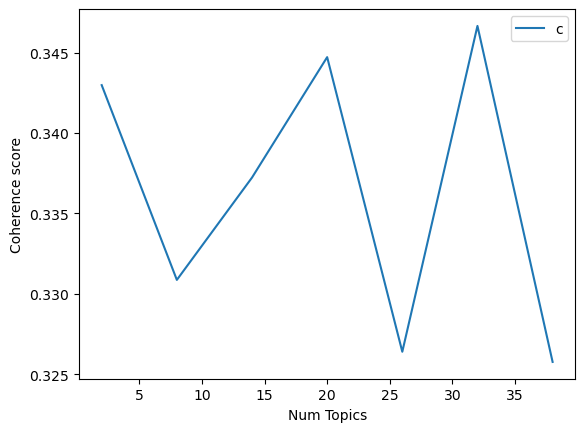

In [6]:
# find optimal number of topics

from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values for different number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Use this function to find the optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['processed_text'].tolist(), start=2, limit=40, step=6)


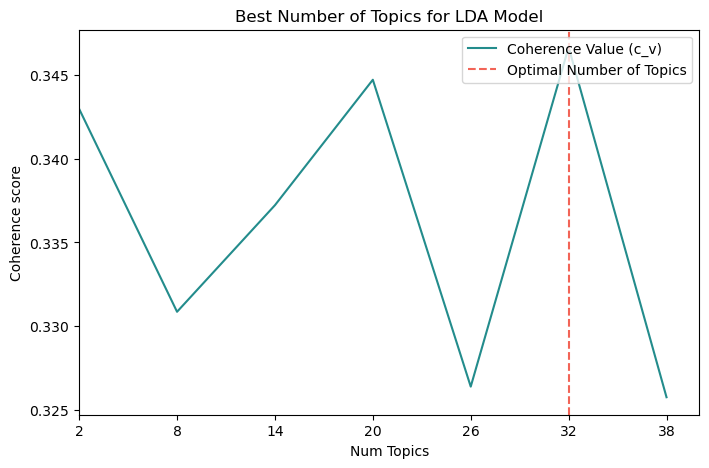

In [7]:
# plot optimal number of topics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(8,5))

# Create a custom x-axis
start = 2
limit = 40
step = 6
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

In [8]:
# Apply LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)



In [9]:
# View the topics
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.056*"abortion" + 0.025*"pregnancy" + 0.025*"abortionishealthcare" + 0.022*"female" + 0.020*"state" + 0.020*"number" + 0.020*"test" + 0.019*"public" + 0.019*"package" + 0.019*"ordered" + 0.018*"publicly" + 0.018*"particularly" + 0.014*"ban" + 0.011*"child" + 0.010*"florida" + 0.009*"care" + 0.009*"weather" + 0.009*"abortionrightsarehumanrights" + 0.008*"forced" + 0.007*"celebrity"')
(1, '0.035*"era" + 0.034*"ever" + 0.034*"friend" + 0.032*"put" + 0.030*"member" + 0.020*"adulthumanfemale" + 0.018*"iran" + 0.014*"girl" + 0.014*"judge" + 0.011*"must" + 0.011*"bathroom" + 0.009*"potus" + 0.009*"trump" + 0.009*"overturning" + 0.009*"cannot" + 0.008*"future" + 0.007*"told" + 0.007*"read" + 0.007*"hypocrisy" + 0.006*"keep"')
(2, '0.051*"woman" + 0.043*"womensrights" + 0.024*"roevwade" + 0.024*"roevswade" + 0.023*"right" + 0.015*"need" + 0.014*"support" + 0.013*"say" + 0.012*"vote" + 0.011*"mybodymychoice" + 0.011*"go" + 0.011*"please" + 0.010*"stand" + 0.010*"small" + 0.010*"power" + 0.

In [10]:
# pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

In [11]:
lda_model_20 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz_20 = gensimvis.prepare(lda_model_20, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz_20)